In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import json

In [2]:
spark = SparkSession.builder \
.master("local") \
.config("spark.sql.autoBroadcastJoinThreshold", -1) \
.config("spark.executor.memory", "500mb") \
.appName("Games") \
.getOrCreate()

22/04/29 00:41:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/29 00:41:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/29 00:41:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df = pd.read_json('./Data/data.json')
df.set_index("id", inplace=True)
cover_df = pd.read_json('./Data/data_url.json')
cover_df.set_index("id", inplace=True)
platform_df = pd.read_json('./Data/data_platforms.json')
platform_df.set_index("id", inplace=True)
genre_df = pd.read_json('./Data/data_genre.json')
genre_df.set_index("id", inplace=True)
gamemode_df = pd.read_json('./Data/data_gamemode.json')
gamemode_df.set_index("id", inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1015
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   aggregated_rating        652 non-null    float64
 1   aggregated_rating_count  652 non-null    float64
 2   category                 1000 non-null   int64  
 3   cover                    1000 non-null   int64  
 4   first_release_date       998 non-null    float64
 5   game_modes               1000 non-null   object 
 6   genres                   999 non-null    object 
 7   name                     1000 non-null   object 
 8   platforms                998 non-null    object 
 9   rating                   832 non-null    float64
 10  rating_count             832 non-null    float64
 11  summary                  973 non-null    object 
 12  total_rating             876 non-null    float64
 13  total_rating_count       876 non-null    float64
dtypes: float64(7), int64(2),

In [5]:
df['Release Year'] = pd.to_datetime(df['first_release_date'], unit='s').dt.year
df = df.drop(columns=['first_release_date','aggregated_rating','aggregated_rating_count','rating','rating_count'])

In [6]:
df['Score Rating'] = (df['total_rating'] + (df['total_rating_count']/1000)).round(2)
df.head(5)

,category,cover,game_modes,genres,name,platforms,summary,total_rating,total_rating_count,Release Year,Score Rating
id,,,,,,,,,,,
1,0,90967,[1],"[5, 13, 31]",Thief II: The Metal Age,[6],The ultimate thief is back! Tread softly as yo...,89.145842,110.0,2000.0,89.26
2,0,96746,[1],"[13, 31]",Thief: The Dark Project,[6],Thief is a first-person stealth game that like...,78.150485,133.0,1998.0,78.28
3,0,129190,[1],"[5, 13, 31]",Thief: Deadly Shadows,"[6, 11]","In the third instalment of the Thief series, m...",82.764675,106.0,2004.0,82.87
4,0,96744,[1],"[5, 31]",Thief,"[6, 9, 12, 48, 49]",There is a rising tide of fear in The City. Ha...,66.713106,251.0,2014.0,66.96
5,0,93899,"[1, 3]",[12],Baldur's Gate,"[3, 6, 14, 39]",Baldur's Gate is a fantasy role-playing video ...,86.813896,256.0,1998.0,87.07


In [7]:
cover_df.head(5)

,url
id,
3975,//images.igdb.com/igdb/image/upload/t_thumb/z7...
3978,//images.igdb.com/igdb/image/upload/t_thumb/cg...
3979,//images.igdb.com/igdb/image/upload/t_thumb/na...
3980,//images.igdb.com/igdb/image/upload/t_thumb/ei...
3983,//images.igdb.com/igdb/image/upload/t_thumb/t0...


In [8]:
platform_df.head(5)

,name
id,
3,Linux
4,Nintendo 64
5,Wii
6,PC (Microsoft Windows)
7,PlayStation


In [9]:
genre_df.head(5)

,name
id,
2,Point-and-click
4,Fighting
5,Shooter
7,Music
8,Platform


In [10]:
df.head(5)

,category,cover,game_modes,genres,name,platforms,summary,total_rating,total_rating_count,Release Year,Score Rating
id,,,,,,,,,,,
1,0,90967,[1],"[5, 13, 31]",Thief II: The Metal Age,[6],The ultimate thief is back! Tread softly as yo...,89.145842,110.0,2000.0,89.26
2,0,96746,[1],"[13, 31]",Thief: The Dark Project,[6],Thief is a first-person stealth game that like...,78.150485,133.0,1998.0,78.28
3,0,129190,[1],"[5, 13, 31]",Thief: Deadly Shadows,"[6, 11]","In the third instalment of the Thief series, m...",82.764675,106.0,2004.0,82.87
4,0,96744,[1],"[5, 31]",Thief,"[6, 9, 12, 48, 49]",There is a rising tide of fear in The City. Ha...,66.713106,251.0,2014.0,66.96
5,0,93899,"[1, 3]",[12],Baldur's Gate,"[3, 6, 14, 39]",Baldur's Gate is a fantasy role-playing video ...,86.813896,256.0,1998.0,87.07


In [11]:
gamemode_df.head(5)

,name
id,
1,Single player
2,Multiplayer
3,Co-operative
4,Split screen
5,Massively Multiplayer Online (MMO)


In [12]:
df.isnull().sum()

category                0
cover                   0
game_modes              0
genres                  1
name                    0
platforms               2
summary                27
total_rating          124
total_rating_count    124
Release Year            2
Score Rating          124
dtype: int64

In [13]:
cover_df.isnull().sum()

url    0
dtype: int64

In [14]:
genre_df.isnull().sum()

name    0
dtype: int64

In [15]:
gamemode_df.isnull().sum()

name    0
dtype: int64

In [16]:
platform_df.isnull().sum()

name    0
dtype: int64

In [17]:
df = df.dropna()

In [18]:
df.isnull().sum()

category              0
cover                 0
game_modes            0
genres                0
name                  0
platforms             0
summary               0
total_rating          0
total_rating_count    0
Release Year          0
Score Rating          0
dtype: int64

<AxesSubplot:>

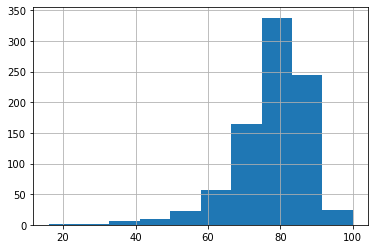

In [19]:
df['Score Rating'].hist(bins=10)

,"[10, 13, 14]","[10, 13, 15, 31]","[10, 13, 30]","[10, 13, 33]","[10, 13]","[10, 14]","[10, 32]","[10, 33]",[10],"[11, 12, 13, 15, 31]",...,"[8, 9, 31]",[8],"[9, 13, 15, 32]","[9, 15]","[9, 25, 31]","[9, 25]","[9, 31, 32]","[9, 31]","[9, 33]",[9]
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
df2 = df[['genres']]
df2

,genres
id,
1,"[5, 13, 31]"
2,"[13, 31]"
3,"[5, 13, 31]"
4,"[5, 31]"
5,[12]
...,...
1011,"[5, 12]"
1012,[5]
1013,"[4, 13, 15, 33]"


In [70]:
df2 = pd.DataFrame(df['genres'].values.tolist(), index=df.index)
df2

,0,1,2,3,4,5
id,,,,,,
1,5,13.0,31.0,NaN,NaN,NaN
2,13,31.0,NaN,NaN,NaN,NaN
3,5,13.0,31.0,NaN,NaN,NaN
4,5,31.0,NaN,NaN,NaN,NaN
5,12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1011,5,12.0,NaN,NaN,NaN,NaN
1012,5,NaN,NaN,NaN,NaN,NaN
1013,4,13.0,15.0,33.0,NaN,NaN


In [75]:
dummies = df['genres'].str.get_dummies()
dummies.head()

,"[10, 13, 14]","[10, 13, 15, 31]","[10, 13, 30]","[10, 13, 33]","[10, 13]","[10, 14]","[10, 32]","[10, 33]",[10],"[11, 12, 13, 15, 31]",...,"[8, 9, 31]",[8],"[9, 13, 15, 32]","[9, 15]","[9, 25, 31]","[9, 25]","[9, 31, 32]","[9, 31]","[9, 33]",[9]
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
